# <center>Car Plugs - Multi-View Image Classification</center>

In [1]:
#=============================================================================================================#
#                                                   IMPORTS                                                   #
#=============================================================================================================#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import time
from PIL import Image
import cv2
import csv
import copy

from collections import OrderedDict
from scipy import spatial
import glob

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import models
import torchvision.transforms as transforms


import pickle
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')


In [2]:
#======================================================================================================================#
#                                           UTILITY FUNCTIONS & GLOBALS                                                #
#======================================================================================================================#
# Class labels to indices
class_id_map = {'cola':1, 
                'milk':2, 
                'banana': 3,
                'yog':0,
                'orange': 4,
                'nut': 5,
                'crem': 6,
                'cand': 7}


## I. Data Processing

This section aims to build a processed image dataset from the original one. The processing steps involve getting rid of some noisy artifacts and converting the gray shades in the background to black.

The folder structure of the project is as follows :

    Multi-View-Image-Classification/
    ├── data/
    │   ├── raw/
    │   │   ├── codename1_x1.png
    │   │   ├── codename1_x2.png
    │   │
    │   │   ...
    │   │
    │   │   ├── codename1_x8.png
    │   │
    │   │   ...
    │   │   
    │   │   ├── codename833_x8.png
    │   │   └── train.csv
    │   ├── processed/
    │   │   ├── codename1_x1_processed.png
    │   │   ├── codename1_x2_processed.png
    │   │
    │   │   ...
    │   │
    │   │   ├── codename1_x8_processed.png
    │   │
    │   │   ...
    │   │   
    │   │   ├── codename833_x8_processed.png
    │   │   └── train.csv
    ├── models/
    │   ├── kmeans.pkl
    │   ├── logistic_regression.pkl
    │   ├── mvcnn_stage_1.pkl
    │   └── mvcnn_state_2.pkl
    ├── notebooks/
    │   ├── Car Plugs - Multi-View Image Classification.ipynb
    │   └── Car Plugs - Multi-View Image Classification.html
    ├── resources/
    │   ├── scaler_mean.npy
    │   ├── scaler_std.npy
    │   └── vocabulary_surf.npy



In [3]:
# GLOBALS

# Data Directory
data_dir = '../data/raw'

# Image Processing Parameters 
BLUR = 21
CANNY_THRESH_1 = 25
CANNY_THRESH_2 = 150
MASK_DILATE_ITER = 10
MASK_ERODE_ITER = 10
MASK_COLOR = (0.0, 0.0, 1.0) # In BGR format

In [4]:
# IMAGE PREPROCESSING FUNCTION (https://stackoverflow.com/questions/29313667/how-do-i-remove-the-background-from-this-kind-of-image)

def preprocess(filename):
    img = cv2.imread(filename)
    imgResized = cv2.resize(img, (0, 0), fx = 0.1, fy = 0.1)
    gray = cv2.cvtColor(imgResized, cv2.COLOR_BGR2GRAY)

    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    
    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]
    
    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))

    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)

    #-- Create final image ---------------------------------------------------------------
    imgResized[mask <= 100] = 0
    return imgResized
 

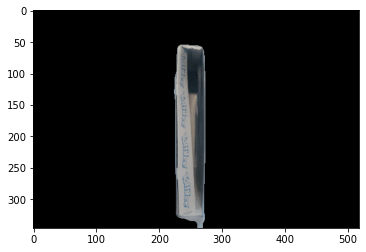

In [6]:
# Preprocessing an example image
filename = '../data/raw/cand1_4.jpg'
img = preprocess(filename)

plt.imshow(img);

In [7]:
# Preprocess all images and Save them to a new directory `processed`

filenames = glob.glob(os.path.join(data_dir, '*.JPG')) # list all image file names in the data folder
proc_data_dir = '../data/processed'

for fname in filenames:
    img_name = os.path.basename(fname)
    img = preprocess(fname)
    cv2.imwrite(os.path.join(proc_data_dir, os.path.splitext(img_name)[0] + '_processed.png'), img)

In [8]:
# Function for visualizing a Car Plug (with all its 8 images)

def show_plug(plug_name, data_dir, preprocess=None):
    # Read Images
    plug_fnames = glob.glob(os.path.join(data_dir, f'{plug_name}*.JPG'))
    print(f'{plug_name}*.JPG')
    if preprocess:
        plug_images = [preprocess(plug_fname) for plug_fname in plug_fnames]
    else:
        plug_images = [cv2.cvtColor(cv2.imread(plug_fname), cv2.COLOR_BGR2RGB) for plug_fname in plug_fnames]
    # Visualize Images
    plt.figure(figsize=(18,8))
    for i in range(len(plug_images)):
        plt.subplot(2, 4, i+1)
        plt.imshow(plug_images[i])
        plt.title(os.path.basename(plug_fnames[i]))
        plt.xticks([])
        plt.yticks([])
        
    plt.suptitle(f'Item: {plug_name}', size=20)
    
    


cola1_1*.JPG
cola1_1*.JPG


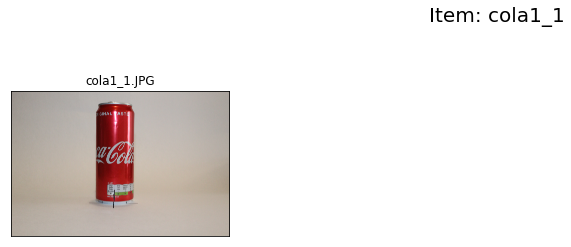

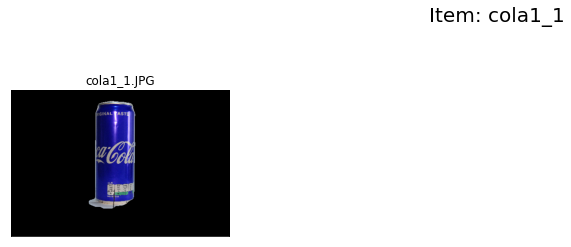

In [9]:
# Example Visualization

plug_name = 'cola1_1'
show_plug(plug_name, data_dir)
show_plug(plug_name, data_dir, preprocess=preprocess)

## II. Feature Extraction & Machine Learning

This chapter presents the first approach we'll be using to solve the problem : a combination of traditional computer vision feature extraction techniques and classical machine learning algorithms. Since we will not be using neural networks, the difficulty here will fall on the engineering aspect of the solution including the formulation of the problem, rather than the fine-tuning and convergence of the model which is the difficulty typically encountered in deep learning.

### 1. Build Vocabulary of Visual Words

The first step is building a vocabulary of visual words. This task relies on one or a combination of multiple traditional computer vision feature extractors such as : HoG, SURF, SIFT etc. Let us first use SURF to extract features from an example image, visualize the key-points identified, then extract features from all of the images (of all car plugs) into a matrix of descriptors. We then use K-means on this matrix to come up with our K visual words (represented by the K centroids).

The number of key points detected: 699


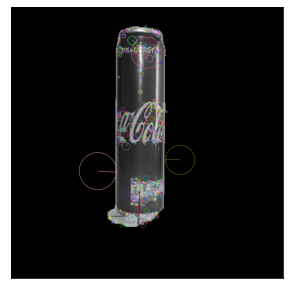

In [10]:
# Detect and Visualize Keypoints in an Image

# Choosing a high value for the hessian threshold in order to visualize only a few key-points to avoid clutter
surf = cv2.SIFT_create(2000) 

img = cv2.imread('../data/processed/cola1_1_processed.png')
img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (900, 900))

kp, descriptors = surf.detectAndCompute(img, None)
print('The number of key points detected:', len(kp))

img_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(5, 5))
plt.imshow(img_kp, cmap='gray')
plt.xticks([])
plt.yticks([]);

In [11]:
# CREATE THE MATRIX OF DESCRIPTORS FROM ALL IMAGES

proc_data_dir = '../data/processed'
filenames = glob.glob(os.path.join(proc_data_dir, '*.png')) # list all image file names in the data folder

surf = cv2.SIFT_create(300)  # create SURF feature extractor


counter = 0
list_descriptors = []

for filename in filenames:
    img = cv2.imread(filename)
    img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (300, 300))
    kp, descriptors = surf.detectAndCompute(img, None)
    if descriptors is not None:
        list_descriptors.append(descriptors)

# This is a matrix where each row is a feature vector extracted from an image (possible to have multiple features per image)      
# And each column is a dimension of the SURF feature vector (total 64, can also be 128 which can be set in the definition of surf) 
descriptor_matrix = np.vstack(list_descriptors)
print('Shape of the Matrix of Descriptors', descriptor_matrix.shape)

Shape of the Matrix of Descriptors (25714, 128)


In [12]:
# CLUSTER FEATURE VECTORS TO CONSTRUCT THE CODEBOOK (i.e VOCABULARY OF VISUAL WORDS)
# Training Kmeans takes time, we save it at the end so we can reload it again later
# Note : bigger K (eg. 500 or 800) will yield better results at the expense of more computation time
K = 200
km = KMeans(n_clusters=K, n_jobs=-1)
km.fit(descriptor_matrix)
centroids = km.cluster_centers_
print('The shape of the centroids:', centroids.shape)

del descriptor_matrix # To free up memory

# Save the k-means model and its centroids
#np.save('../resources/vocabulary_surf.npy', centroids)
#pickle.dump(km, open('../models/kmeans.pkl', 'wb'))

The shape of the centroids: (200, 128)


### 2. Build Matrix of Feature Vectors

Here, we build the matrix of feature vectors by transforming each Car Plug (8 images) into a vector of size K (number of clusters from before). For each Car Plug we process all its image views, extract their SURF descriptors, find the cluster of each descriptor (i.e. the visual word associated with the descriptor), then count the number of times each visual word (i.e. cluster) occurs. We end up with a feature vector of size K for that Car Plug. Stacking these feature vectors vertically results in a NxK matrix where each row represents a Car Plug and each column, a visual word and each cell, the number of times the visual word occurs in the Car Plug (i.e all of its image views).

In [13]:
# FUNCTION DEFINITION : turns a car plug (set of 8 images) into a feature vector of size K through image quantization.
# We use the K-means model trained on the matrix of descriptors
# Iterate through the images of plug, process each image, create its SURF feature vectors
# Predict the cluster of each feature vector, add 1 to the output vector at the location of the predicted cluster (Quantization)

def get_feature_vec(plug_name, model, preprocess=None, surf_threshold=200):
    
    feature_vec = np.zeros(K) # Intialize vector representation of visual words
    
    surf = cv2.SIFT_create(surf_threshold)
    
    plug_fnames = glob.glob(os.path.join(proc_data_dir, f'{plug_name}_*.png'))
    if preprocess:
        plug_images = [cv2.resize(cv2.cvtColor(preprocess(plug_fname), cv2.COLOR_BGR2GRAY), (300, 300)) for plug_fname in plug_fnames] 
    else:
        plug_images = [cv2.resize(cv2.cvtColor(cv2.imread(plug_fname), cv2.COLOR_BGR2GRAY), (300, 300)) for plug_fname in plug_fnames] 
    
    for image in plug_images: # iterate over the image views of the car plug
        kp, descriptors = surf.detectAndCompute(image, None) # extract the surf descriptors of the image
        if descriptors is not None:
            visual_words = model.predict(descriptors) # find all the visual words in the image
            for visual_word in visual_words: # find the occurence of each visual word
                feature_vec[visual_word] += 1

    return feature_vec


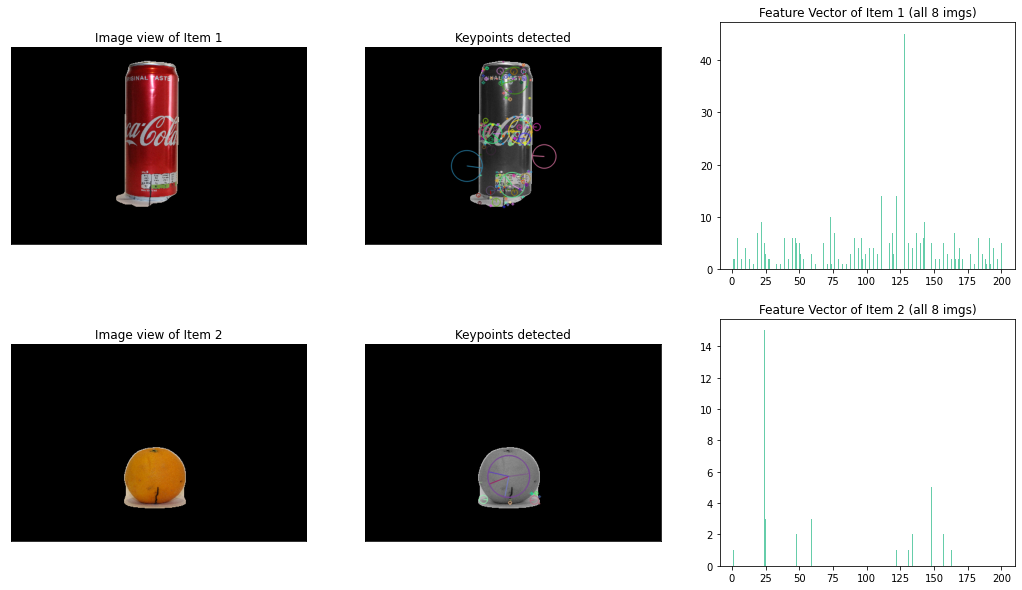

In [14]:
# Example : Visualizing the feature vector of two images as a bar graph

plug_name_1 = 'cola1'
plug_name_2 = 'orange1'

plug_fname_1 = os.path.join(proc_data_dir, f'{plug_name_1}_1_processed.png')
plug_fname_2 = os.path.join(proc_data_dir, f'{plug_name_2}_1_processed.png')

img_1 = cv2.cvtColor(cv2.imread(plug_fname_1), cv2.COLOR_BGR2RGB)
img_2 = cv2.cvtColor(cv2.imread(plug_fname_2), cv2.COLOR_BGR2RGB)


kp_1 = surf.detect(img_1)
kp_2 = surf.detect(img_2)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.imshow(img_1)
plt.title('Image view of Item 1')
plt.xticks([]); plt.yticks([]) 
plt.subplot(2, 3, 2)
plt.imshow(cv2.drawKeypoints(cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY), kp_1, None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS))
plt.title('Keypoints detected')
plt.xticks([]); plt.yticks([]) 
plt.subplot(2, 3, 3)
plt.bar(np.arange(1, K+1), get_feature_vec(plug_name_1, km), color='mediumaquamarine', width=0.3)
plt.title('Feature Vector of Item 1 (all 8 imgs)')

plt.subplot(2, 3, 4)
plt.imshow(img_2)
plt.title('Image view of Item 2')
plt.xticks([]); plt.yticks([]) 
plt.subplot(2, 3, 5)
plt.imshow(cv2.drawKeypoints(cv2.cvtColor(img_2, cv2.COLOR_RGB2GRAY), kp_2, None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS))
plt.title('Keypoints detected')
plt.xticks([]); plt.yticks([]) 
plt.subplot(2, 3, 6)
plt.bar(np.arange(1, K+1), get_feature_vec(plug_name_2, km), color='mediumaquamarine', width=0.3)
plt.title('Feature Vector of Item 2 (all 8 imgs)');

In [15]:
# BUILD THE MATRIX OF FEATURE VECTORS (NxK)

plug_names = np.unique([fname.split('_')[0] for fname in os.listdir(proc_data_dir) if fname.endswith('.png')])
print(plug_names)
N = len(plug_names)
print(f'There are {N} Item types.')

X = np.empty((N, K))

for i, plug_name in enumerate(plug_names):
    X[i] = get_feature_vec(plug_name, km)

print('Shape of the feature matrix', X.shape)

['banana1' 'banana2' 'banana3' 'banana4' 'cand1' 'cand2' 'cand3' 'cola1'
 'cola2' 'cola3' 'cola4' 'crem1' 'crem2' 'crem3' 'crem4' 'milk1' 'milk2'
 'milk3' 'milk4' 'nut1' 'nut2' 'nut3' 'nut4' 'orange1' 'orange2' 'orange3'
 'orange4' 'yog1' 'yog2' 'yog3' 'yog4']
There are 31 Item types.
Shape of the feature matrix (31, 200)


### 3. Train a Machine Learning Model

In [16]:
# GET CAR PLUG LABELS
df_class_map = pd.read_csv('../data/processed/train.csv')
df_class_map.head()

print(plug_names)
labels = [df_class_map.loc[df_class_map.part_no == plug_name, 'label'].item() for plug_name in plug_names]
labels[:10]

y = np.array([class_id_map[label] for label in labels]) # Encode the string labels into code numbers
y[:10]

['banana1' 'banana2' 'banana3' 'banana4' 'cand1' 'cand2' 'cand3' 'cola1'
 'cola2' 'cola3' 'cola4' 'crem1' 'crem2' 'crem3' 'crem4' 'milk1' 'milk2'
 'milk3' 'milk4' 'nut1' 'nut2' 'nut3' 'nut4' 'orange1' 'orange2' 'orange3'
 'orange4' 'yog1' 'yog2' 'yog3' 'yog4']


array([3, 3, 3, 3, 7, 7, 7, 1, 1, 1])

In [17]:
# TRAIN-TEST SPLIT
rnd = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=rnd)

In [18]:
# NORMALIZE DATA
m = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - m)/std
X_test = (X_test - m)/std

# Need to save mean and std of training data, we use these values to normalize test data and new data as well
#np.save('../resources/scaler_mean', m)
#np.save('../resources/scaler_std', std)

In [19]:
# TRAIN A LOGISTIC REGRESSION MODEL 
# We using cost-sensitive learning by providing the class weights to steer the learning towards making less costly mistakes as represented by the weights

print(y_train, X_train)
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, 
                          y_pred)

print(f'The accuracy of Logistic Regression is {round(accuracy*100, 2)}%')

[6 0 1 0 3 2 1 4 2 1 2 7 0 7 6 4 5 5 3 5 4] [[-0.05719389 -0.36011329 -0.64081697 ...  0.06279195 -0.47783869
   0.17636723]
 [-0.32409872  1.22271024 -0.26700707 ...  0.39244969  2.03081441
   0.17636723]
 [-1.12481321 -0.00837473  0.85442263 ... -0.59652352 -0.47783869
  -0.16033384]
 ...
 [-0.59100355 -0.53598257 -1.01462687 ... -0.92618126 -1.03531715
  -1.17043705]
 [ 1.94459232 -0.53598257  0.48061273 ...  0.72210742 -0.19909945
   0.17636723]
 [-1.12481321 -0.36011329 -1.01462687 ... -1.255839   -1.03531715
  -1.17043705]]
The accuracy of Logistic Regression is 90.0%


In [20]:
# SAVE THE MODEL
pickle.dump(lr, open('../models/logistic_regression.pkl', 'wb'))

**Comment :**

Although the accuracy seems high, it has a very large variance. If we resample the training and test set again, we may obtain a very different performance value. The values typically range between 76% and 94% with an average around 87%.

In [21]:
# FUNCTION TO GET PREDICTIONS FOR NEW CAR PLUGS

def lr_pred(plug_name, data_dir, pred_model, clus_model, scaler_mean, scaler_std):

    feature_vec = get_feature_vec(plug_name, clus_model, preprocess=preprocess)
    feature_vec = (feature_vec - scaler_mean) / scaler_std
    pred = pred_model.predict(feature_vec.reshape(1, -1))[0]
    return pred, {v:k for k,v in class_id_map.items()}[pred]


In [31]:
# GET NEW PREDICTIONS FROM RAW IMAGES USING A CAR PLUG NAME
plug_name = 'orange4'
lr_pred(plug_name, data_dir, lr, km, m, std)

(4, 'orange')

## III. Multi-View Convolutional Neural Network (MVCNN)

## 1. Create A Custom PyTorch Dataset

In [32]:
class CarPlugDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.nb_views = 8
        self.plug_label_map = self._get_plug_label_map(root + '/train.csv')
        self.plug_names = self._get_plug_names(root)
        self.label_encoder = {'cola':1, 
                'milk':2, 
                'banana': 3,
                'yog':0,
                'orange': 4,
                'nut': 5,
                'crem': 6,
                'cand': 7} 
        
    def _get_plug_names(self, root):
        plug_names = [fname.split('_')[0] for fname in os.listdir(root) if fname.endswith('.png')]
        plug_names = list(set(plug_names))
        return plug_names
    
    def _get_plug_label_map(self, filename):
        reader = csv.DictReader(open(filename))
        plug_label_map = {}
        for row in reader:
            plug_label_map[row['part_no']] = row['label']
        return plug_label_map
        
    def __len__(self):
        return len(self.plug_names)
    
    def _transform(self, image):
        transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
        return transform(image)
    
    def __getitem__(self, index):
        plug_name = self.plug_names[index]
        # Get Images of the Plug
        plug_fnames = glob.glob(self.root + f'/{plug_name}_*.png')
        plug = torch.stack([self._transform(Image.open(fname).convert('RGB')) for fname in plug_fnames])
        label = self.label_encoder[self.plug_label_map[plug_name]]
        return plug, label
    
     

In [33]:
# CREATE DATASET
root = '../data/processed'
dataset = CarPlugDataset(root)
len(dataset)

31

In [68]:
# CREATE STRATIFIED TRAIN-VALIDATION SPLIT INDICES
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
y = [dataset.plug_label_map[plug] for plug in dataset.plug_names]

train_indices, val_indices = next(sss.split(np.zeros(len(y)), y))

In [69]:
# CREATE TRAIN AND VALIDATION DATA LOADERS
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=31, sampler=train_sampler, num_workers=0)
val_loader = DataLoader(dataset, batch_size=31, sampler=val_sampler, num_workers=0)
data_loaders = {'train': train_loader, 'val': val_loader}

## 2. Create the Multi-View CNN (MVCNN) Architecture 

In [70]:
# MULTI-VIEW CONVOLUTIONAL NEURAL NETWORK (MVCNN) ARCHITECTURE

class MVCNN(nn.Module):
    def __init__(self, num_classes=1000, pretrained=True):
        super(MVCNN, self).__init__()
        resnet = models.resnet34(pretrained = pretrained)
        fc_in_features = resnet.fc.in_features
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(fc_in_features, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes)
        )

    def forward(self, inputs): # inputs.shape = samples x views x height x width x channels
        inputs = inputs.transpose(0, 1)
        view_features = [] 
        for view_batch in inputs:
            view_batch = self.features(view_batch)
            view_batch = view_batch.view(view_batch.shape[0], view_batch.shape[1:].numel())
            view_features.append(view_batch)   
            
        pooled_views, _ = torch.max(torch.stack(view_features), 0)
        outputs = self.classifier(pooled_views)
        return outputs

In [71]:
# BUILD AND VISUALIZE THE MODEL
model = MVCNN(num_classes=8, pretrained=True)
print(model)

MVCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


## 3. Train the MVCNN Model

In [72]:
# DEFINE THE DEVICE
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [73]:
# DEFINE A FUNCTION TO TRAIN THE MODEL

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    # Get model predictions
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.append(preds)
                all_labels.append(labels)

            epoch_loss = running_loss / len(dataloaders[phase].sampler.indices)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].sampler.indices)
            all_labels = torch.cat(all_labels, 0)
            all_preds = torch.cat(all_preds, 0)
            epoch_weighted_acc = accuracy_score(all_labels.cpu().numpy(), all_preds.cpu().numpy())
            

            print('{} Loss: {:.4f} - Acc: {:.4f} - Weighted Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_weighted_acc))

            # deep copy the model
            if phase == 'val' and epoch_weighted_acc > best_acc:
                best_acc = epoch_weighted_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_weighted_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

### 3.1 Training the Classifier Block of the Network

In [74]:
# FREEZE THE WEIGHTS IN THE FEATURE EXTRACTION BLOCK OF THE NETWORK (I.E. RESNET BASE)
for param in model.features.parameters():
    param.requires_grad = False

In [75]:
# TRAIN THE CLASSIFIER BLOCK OF THE MODEL (I.E TOP DENSE LAYERS)
model.to(device)
EPOCHS = 40
weight = None
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0005)

model, val_acc_history = train_model(model=model, dataloaders=data_loaders, criterion=criterion, optimizer=optimizer, num_epochs=EPOCHS)

Epoch 1/40
----------
train Loss: 2.2735 - Acc: 0.0952 - Weighted Acc: 0.0952
val Loss: 2.2087 - Acc: 0.1000 - Weighted Acc: 0.1000

Epoch 2/40
----------
train Loss: 1.9574 - Acc: 0.1905 - Weighted Acc: 0.1905
val Loss: 2.0851 - Acc: 0.2000 - Weighted Acc: 0.2000

Epoch 3/40
----------
train Loss: 1.7363 - Acc: 0.2857 - Weighted Acc: 0.2857
val Loss: 1.9051 - Acc: 0.2000 - Weighted Acc: 0.2000

Epoch 4/40
----------
train Loss: 1.6575 - Acc: 0.5714 - Weighted Acc: 0.5714
val Loss: 1.7150 - Acc: 0.7000 - Weighted Acc: 0.7000

Epoch 5/40
----------
train Loss: 1.5444 - Acc: 0.6190 - Weighted Acc: 0.6190
val Loss: 1.5160 - Acc: 0.8000 - Weighted Acc: 0.8000

Epoch 6/40
----------
train Loss: 1.4925 - Acc: 0.6190 - Weighted Acc: 0.6190
val Loss: 1.3706 - Acc: 0.6000 - Weighted Acc: 0.6000

Epoch 7/40
----------
train Loss: 1.0695 - Acc: 0.8571 - Weighted Acc: 0.8571
val Loss: 1.2304 - Acc: 0.8000 - Weighted Acc: 0.8000

Epoch 8/40
----------
train Loss: 1.0940 - Acc: 0.8095 - Weighted Acc

In [76]:
# SAVE CURRENT WEIGHTS OF THE MODEL (STAGE 1: FEATURE EXTRACTION)
torch.save(model.state_dict(), '../models/mvcnn_stage_1.pkl')

### 3.2 Fine-Tuning the Entire Network (Feature Extractor + Classifier Blocks)

In [77]:
# UNFREEZE ALL THE WEIGHTS OF THE NETWORK
for param in model.parameters():
    param.requires_grad = True

In [78]:
# FINE-TUNE THE ENTIRE MODEL (I.E FEATURE EXTRACTOR + CLASSIFIER BLOCKS) USING A VERY SMALL LEARNING RATE
EPOCHS = 20
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.Adam(model.parameters(), lr=0.00005) # We use a smaller learning rate

model, val_acc_history = train_model(model=model, dataloaders=data_loaders, criterion=criterion, optimizer=optimizer, num_epochs=EPOCHS)

Epoch 1/20
----------
train Loss: 0.9722 - Acc: 0.7619 - Weighted Acc: 0.7619
val Loss: 0.9331 - Acc: 1.0000 - Weighted Acc: 1.0000

Epoch 2/20
----------
train Loss: 0.6986 - Acc: 0.8571 - Weighted Acc: 0.8571
val Loss: 0.8722 - Acc: 1.0000 - Weighted Acc: 1.0000

Epoch 3/20
----------
train Loss: 0.7232 - Acc: 0.9524 - Weighted Acc: 0.9524
val Loss: 0.8151 - Acc: 1.0000 - Weighted Acc: 1.0000

Epoch 4/20
----------
train Loss: 0.6102 - Acc: 0.9524 - Weighted Acc: 0.9524
val Loss: 0.7576 - Acc: 0.9000 - Weighted Acc: 0.9000

Epoch 5/20
----------
train Loss: 0.4082 - Acc: 0.9524 - Weighted Acc: 0.9524
val Loss: 0.7191 - Acc: 0.9000 - Weighted Acc: 0.9000

Epoch 6/20
----------
train Loss: 0.2815 - Acc: 1.0000 - Weighted Acc: 1.0000
val Loss: 0.6940 - Acc: 0.8000 - Weighted Acc: 0.8000

Epoch 7/20
----------
train Loss: 0.3430 - Acc: 0.9524 - Weighted Acc: 0.9524
val Loss: 0.6706 - Acc: 0.8000 - Weighted Acc: 0.8000

Epoch 8/20
----------
train Loss: 0.3415 - Acc: 0.9524 - Weighted Acc

In [79]:
# SAVE CURRENT WEIGHTS OF THE MODEL (STAGE 2: FINE-TUNING)
torch.save(model.state_dict(), '../models/mvcnn_stage_2.pkl')

In [80]:
# FUNCTION TO GET PREDICTIONS FOR NEW CAR PLUGS
def mvcnn_pred(plug_name, data_dir, model, device):
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    plug_fnames = glob.glob(data_dir + f'/{plug_name}_*.png')
    plug = torch.stack([transform(Image.open(fname).convert('RGB')) for fname in plug_fnames]).unsqueeze(0)
    plug = plug.to(device)
    pred = torch.nn.functional.softmax(model(plug)).argmax().item()
    return pred, {v:k for k,v in class_id_map.items()}[pred]



In [85]:
# GET NEW PREDICTIONS FROM RAW IMAGES USING A CAR PLUG NAME
plug_name = 'cola3'
mvcnn_pred(plug_name, '../data/processed', model, device)

(1, 'cola')